In [1]:
import numpy as np
import cv2
from numpy import random
import matplotlib.pyplot as plt
import pdb
import math as mp
from IPython.display import clear_output

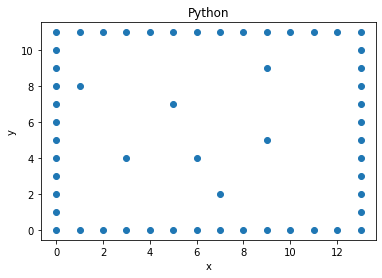

In [2]:
# prepare the world
map = cv2.imread('map2.png')
map = cv2.copyMakeBorder(map,1,1,1,1,cv2.BORDER_CONSTANT,value=0)  #zero padding
red = map[:,:,1]
#Slice the red array
pp = np.copy(red)  #use np.copy for creating copies
red[pp>100]=0
red[pp<100]=255
playg =red
playg[playg!=0]=1
[ydim,xdim] = playg.shape


#Generate environment to plot

r = int(0)
c = int(0)
x_p = []
y_p = []
while(r<ydim):
    c=0
    while(c<xdim):
        if(playg[r,c]==1):
            x_p.append(c)
          
            y_p.append(r)
        c = c+1
 
    r = r+1
    
    
plt.scatter(x_p,y_p)
plt.title('Python')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [3]:
def get_local_area(pos):  # checked 
    
    
    # add detect collision to it without the function.
    
    row = int(pos[1]); col = int(pos[0])
    area = np.zeros((3,3),dtype = int)
    
    area = playg[row-1:row+2,col-1:col+2]
    return area,(playg[row,col]==1)
    #but what if we have pos at row =0 or row = dim -1 or col = 0  or col = dim2 - 1. So we did zero padding.
    
    
    

In [4]:
def get_actual_state2(pos,goal):  # checked works for now manualy    # this is for neural network
    a_state = np.zeros((8,2),dtype= int)   #(8,1) is obs and (8,1) is direction
    #crop the image at the location  
    error_angle =  mp.atan2((goal[1]-pos[1]),(goal[0]-pos[0]))
    local_area,is_collided = get_local_area(pos)
    angle = mp.pi/4
    index = np.round(error_angle/angle)
    if(not is_collided):
        
        if(index==8):
            index=0
        a_state[int(index),1] = 1  # put the direction in which goal is present   
        for i in range(8):
            x = np.round(mp.cos(angle*i))
            y = np.round(mp.sin(angle*i))
            x = x+1
            y = y-1
            c = int(x)
            r = int(y)
            #print('xy ',x-1,y-1,'rc',r,c)
            a_state[i,0] = local_area[r,c]

     
    return a_state,is_collided     
            
        
        
        

In [5]:
def get_actual_state(pos,goal):  # checked works for now manualy    # this is for tabular
    l_state = np.zeros((8,),dtype= int)   #(8,1) is obs and (8,1) is direction
    a_state = np.zeros((2,),dtype=int)
    #crop the image at the location  
    error_angle =  mp.atan2((goal[1]-pos[1]),(goal[0]-pos[0]))
    local_area,is_collided = get_local_area(pos)
    angle = mp.pi/4
    index = np.round(error_angle/angle)
    if(index==8):
        index=0
    if(not is_collided):
        for i in range(8):
            x = np.round(mp.cos(angle*i))
            y = np.round(mp.sin(angle*i))
            x = x+1
            y = y-1
            c = int(x)
            r = int(y)
            #print('xy ',x-1,y-1,'rc',r,c)
            l_state[i] = local_area[r,c]


        #print(local_area)
        #print(l_state)
        a_state[0] = encode_l_state(l_state)
        a_state[1] = index
    return a_state,is_collided     
            
        
        
        

In [6]:
def encode_l_state(List): # checked works. # converts binary list to a integer.
    result = 0
    for digits in List:
        result = (result << 1) | digits
    return result

4095

In [7]:

#< 0 ,M 1, > 2,V 3

# numpy refers by address, its an object.
def get_next_state(pos,goal,action):  # checked works fine manually but has problem if goes at border
        
        new_state = np.copy(pos)
        if(action==0):
            new_state[0]-=1
        elif(action==1):
            new_state[1]+=1
        elif(action==2):
            new_state[0]+=1
        elif(action==3):
            new_state[1]-=1
        
        ss,is_collided = get_actual_state(new_state,goal)
        return ss,is_collided,new_state
    
            

In [8]:
def detect_collision(state):
    col = False
    [dim1,dim2]=playg.shape
    if(state[1]>=dim1-1 or state[0]>dim2-1 or state[1]<0 or state[0]<0):
        col=True
    elif(playg[state[1],state[0]]==1):
        col = True
    return col

In [17]:
def get_reward(c_state,taken_action,f_state):
    rewardd =-1
    c_dis = np.sum(f_state-c_state)
   
    p_dis = np.sum(f_state - prev_state)
   
    dis = p_dis-c_dis
    
    if(detect_collision(c_state)):
        rewardd = -10
    elif(np.sum(c_state == f_state)==2):
        rewardd = 100
    elif(dis<0):
        rewardd=-1
    
    return rewardd

In [10]:
def get_action(Q_value):
    ran = random.rand(1)  #Generates random float number between 0-1
    rn = ran[0]
    if(rn>epsilon):
        action=find_max_index(Q_value)
        return action
    else:
        action = random.randint(4)  # generate random number betwween 0-3
        return action

In [11]:
def find_max_index(array):
    max_no=-100000000000
    max_in=0
    for i in range(len(array)):
        if(array[i]>max_no):
            max_no=array[i]
            max_in=i
    return max_in
        

In [12]:
#EPISODE_PLOTTER
def plot_episode(x_co,y_co):
    x_co = 10*x_co
    y_co = 10*y_co
    #plot environment
    plt.scatter(x_p,y_p)
    #plot vehicle path
    plt.plot(x_co,y_co)
    plt.title('Vehicle plot')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [44]:
#Issue

# is_collided was only telling whether it hit the border or not and not the actual collisions
#using detect_collision is too slow.

#Typo in get reward it was rewardd for going towards goal.

In [13]:
#state space.shape = [2,1]  state_space[1] --> 0-255 obstacle category   state_space[2]--> 0-8goal direction

#Qvalue.shape = [no_of_state_values,no_direction_values,no_of_action]

#paramameters

epsilon = 0.1
gamma = 0.95
alpha = 0.1

no_episodes =4000
start_pos = np.ones((2,),dtype = int)
goal = np.ones((2,),dtype = int)
goal[0]=int(11)
goal[1] = int(8)

Q= np.zeros((256,8,4),dtype = float)
        #print(done)   
s_state,temp=get_actual_state(start_pos,goal)
s1 = s_state[0]
s2 = s_state[1]
action = get_action(Q[s1,s2,:])
curr_pos = np.copy(start_pos)
n_pos = np.copy(start_pos)






for i in range(no_episodes):
    
    curr_pos = np.copy(start_pos)
    s_state,temp=get_actual_state(curr_pos,goal)
    s1 = s_state[0]
    s2 = s_state[1]
    action = get_action(Q[s1,s2,:])
    done = False
    n_action=0
    clear_output(wait=True)
    if(i<100):
        epsilon = 0.8
    elif(i>100 or i<300):
        epsilon = 0.4
    else:
        epsilon = 0.1
    #epsilon = 1.001  - i/no_episodes/2
    
    print('Episode no ',i)
    while(not done):
        n_state,is_collided,n_pos = get_next_state(curr_pos,goal,action)
        
        reward = get_reward(n_pos,curr_pos,goal)
       
        curr_state,temp = get_actual_state(curr_pos,goal)
        
        cs1 = curr_state[0]
        cs2 = curr_state[1]
        #print(curr_pos,cs1,cs2,reward)
        if(is_collided):
            Q[cs1,cs2,action]+= alpha*(reward)
            break
            #print('Q',Q[cs1,cs2,action])
        else:
            n_action = get_action(Q[n_state[0],n_state[1],:])
            Q[cs1,cs2,action]+= alpha*(reward + gamma*Q[n_state[0],n_state[1],n_action]-Q[cs1,cs2,action])
         
        #print(Q[n_state[0],n_state[1],:],' action ',n_action,' for pos ',n_pos,' reward ', reward)
        
        curr_pos =np.copy(n_pos)
        #x_j.append(n_pos[0])
        #y_j.append(n_pos[1])
        action = n_action
        
        if(reward==100 or is_collided):  # compare with max reward.
            #print('Goal Achieved')
            done = True
       
        
       
    
    
    
    
    

Episode no  3999


In [23]:
# Manual Check
epsilon = 0.1
gamma = 0.95
alpha = 0.1

no_episodes =3
start_pos = np.ones((2,),dtype = int)
goal = np.ones((2,),dtype = int)
goal[0]=int(11)
goal[1] = int(8)

#Q= np.zeros((256,8,4),dtype = float)
        #print(done)   
s_state,temp=get_actual_state(start_pos,goal)
s1 = s_state[0]
s2 = s_state[1]
action = get_action(Q[s1,s2,:])
curr_pos = np.copy(start_pos)
n_pos = np.copy(start_pos)






for i in range(no_episodes):
    
    curr_pos = np.copy(start_pos)
    s_state,temp=get_actual_state(curr_pos,goal)
    s1 = s_state[0]
    s2 = s_state[1]
    action = get_action(Q[s1,s2,:])
    done = False
    n_action=0
    #clear_output(wait=True)
    #epsilon = 1.001  - i/no_episodes/2
    '''
    if(i%100==0 and i>1):
        print(i)
        print(Q[n_state[0],n_state[1],:], 'for state ',n_state[0],n_state[1], 'goal distance ',np.sum(goal-n_pos),' action ',n_action,' for pos ',n_pos)
        plot_episode(x_j,y_j)
   
    x_j = []
    y_j = []
    
    '''
    
    print('Episode no ',i)
    while(not done):
        n_state,is_collided,n_pos = get_next_state(curr_pos,goal,action)
        
        reward = get_reward(n_pos,curr_pos,goal)
       
        curr_state,temp = get_actual_state(curr_pos,goal)
        
        cs1 = curr_state[0]
        cs2 = curr_state[1]
        #print(curr_pos,cs1,cs2,reward)
        if(is_collided):
            Q[cs1,cs2,action]+= alpha*(reward)
            break
            #print('Q',Q[cs1,cs2,action])
        else:
            n_action = get_action(Q[n_state[0],n_state[1],:])
            Q[cs1,cs2,action]+= alpha*(reward + gamma*Q[n_state[0],n_state[1],n_action]-Q[cs1,cs2,action])
        #print('Qcurr changed of',Q[cs1,cs2,:], 'for pose ',curr_pos, 'is collided',is_collided,n_pos )
        print('Qnext ',Q[n_state[0],n_state[1],:],' action ',n_action,' for pos ',n_pos,' reward ', reward)
        
        curr_pos =np.copy(n_pos)
        #x_j.append(n_pos[0])
        #y_j.append(n_pos[1])
        action = n_action
        
        if(np.sum(curr_pos==goal)==2 or is_collided):
            done = True
        
       
    
    
    
    
    

Episode no  0
Qnext  [-340.          -96.26423616  -49.89273665 -140.07234223]  action  2  for pos  [1 2]  reward  -1
Qnext  [-61.0023095  -60.74993473 -45.66907229 -89.7350491 ]  action  2  for pos  [2 2]  reward  -1
Qnext  [-61.0023095  -60.74993473 -49.72699472 -89.7350491 ]  action  3  for pos  [3 2]  reward  -1
Qnext  [-163.35101016  -57.72066116  -88.69969139 -329.        ]  action  1  for pos  [3 1]  reward  -1
Qnext  [-61.0023095  -60.74993473 -49.72699472 -86.345007  ]  action  2  for pos  [3 2]  reward  -1
Qnext  [-61.0023095  -60.74993473 -49.57835975 -86.345007  ]  action  2  for pos  [4 2]  reward  -1
Qnext  [-61.0023095  -60.74993473 -49.43046795 -86.345007  ]  action  2  for pos  [5 2]  reward  -1
Qnext  [ -36.97312343  -34.33540793 -242.          -48.68778565]  action  1  for pos  [6 2]  reward  -1
Qnext  [-40.84371531 -38.10584138 -32.71351617 -42.99833811]  action  2  for pos  [6 3]  reward  -1
Qnext  [-32.47719246 -38.09898065 -30.17080716 -75.        ]  action  2  f

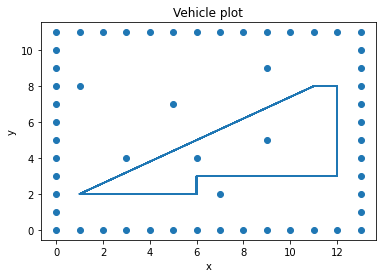

In [25]:
plot_episode(x_j,y_j)

In [24]:
#generate the trajectory
position = np.ones((2,),dtype = int)
epsilon=0
x_j = []
y_j = []
done=False
count=0
curr_pos = np.copy(start_pos)

count=0
while(not done):
    # get the encoded state
    
    n_state,temp = get_actual_state(curr_pos,goal)
    n_action = get_action(Q[n_state[0],n_state[1],:])
    n_state,is_collided,n_pos = get_next_state(curr_pos,goal,n_action)
    curr_pos = np.copy(n_pos)
    #print(curr_pos)
    x_j.append(curr_pos[0])
    y_j.append(curr_pos[1])
    count+=1
    print(count,curr_pos)
    clear_output(wait=True)
    if(np.sum(curr_pos==goal)==2 or detect_collision(curr_pos)):
            done = True
        


19 [11  8]


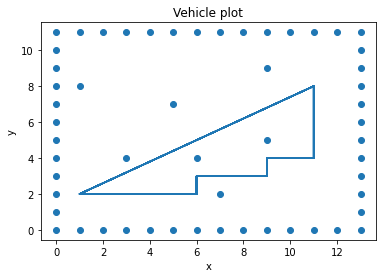

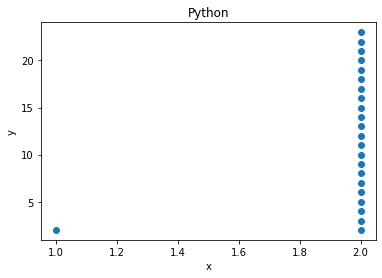

In [33]:
plt.scatter(x_j,y_j)
plt.title('Python')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [49]:
detect_collision([x_j[-1],y_j[-1]])

True

In [ ]:
Q

In [20]:
i

3577